In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model,load_model
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPool2D
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam


In [ ]:
#for cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
#normalize inputs and one hot encode labels
x_train = x_train/255.0
x_test = x_test/255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [ ]:
#parameters for training
batch_size = 32
epochs = 20
lr = 1e-3
input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [ ]:
#layer definition, the inpurt parameters are set to default values.
def resnet_layer(inputs, num_filters = 16, kernel_size = (3,3), strides = 1, activation = 'relu', batch_normalization= True, conv_first=True):
  conv = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
  x = inputs
  if conv_first:
    x = conv(x)
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
  else:
    if batch_normalization:
      x = BatchNormalization()(x)
      if activation is not None:
        x = Activation(activation)(x)
      x = conv(x)
  return x

In [ ]:
#Resnet20 definition. Each block(identity/convolutional block) has 2 convolutional layer, each stack has 6 layers.
def model(input_shape):
  #first convultional layer 3x3, filters = 16
  inputs = Input(shape = input_shape)
  x = resnet_layer(inputs=inputs,num_filters=16,conv_first=True)

  #first layer first stack
  y = resnet_layer(inputs=x,num_filters=16,strides=1)
  #conv,batch normalization,activation

  #second layer first stack
  y = resnet_layer(inputs=y,num_filters=16,strides=1,activation=None)
  #conv,batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #1st identity block over

  #third layer first stack
  y = resnet_layer(inputs=x,num_filters=16,strides=1)
  #conv, batch normalization, activation

  #fourth layer first stack
  y = resnet_layer(inputs=y,num_filters=16,strides=1,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #2nd identity block over

  #fifth layer first stack
  y = resnet_layer(inputs=x,num_filters=16,strides=1)
  #conv, batch normalization, activation

  #sixth layer first stack
  y = resnet_layer(inputs=y,num_filters=16,strides=1,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #3rd identity block over

  #first layer second stack, num_filters =32 now
  y = resnet_layer(inputs=x,num_filters=32,strides=2)
  #conv, batch normalization, activation

  #second layer second stack
  y = resnet_layer(inputs=y,num_filters=32,activation=None)
  #conv, batch normalization

  x = resnet_layer(inputs=x,num_filters=32,kernel_size=1,strides=2,activation = None, batch_normalization=False)
  x = Add()([x,y])
  x = Activation('relu')(x)
  #convolutional block ends

  #third layer second stack
  y = resnet_layer(inputs=x,num_filters=32,strides=1)
  #conv, batch normalization, activation

  #fourth layer second stack
  y = resnet_layer(inputs=y,num_filters=32,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block

  #fifth layer second stack
  y = resnet_layer(inputs=x,num_filters=32,strides=1)
  #conv, batch normalization, activation

  #sixth layer second stack
  y = resnet_layer(inputs=y,num_filters=32,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block

  #first layer third stack, num_filters =64 now
  y = resnet_layer(inputs=x,num_filters=64,strides=2)
  #conv, batch normalization, activation

  #second layer third stack
  y = resnet_layer(inputs=y,num_filters=64,activation=None)
  #conv, batch normalization


  x = resnet_layer(inputs = x, num_filters=64, kernel_size=1,strides=2,activation=None,batch_normalization=False)
  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of convolutional block

  #third layer third stack
  y = resnet_layer(inputs=x,num_filters=64,strides=1)
  #conv, batch normalization, activation

  #fourth layer third stack
  y = resnet_layer(inputs=y,num_filters=64,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block

  #fifth layer third stack
  y = resnet_layer(inputs=x,num_filters=64,strides=1)
  # conv, batch normalization, activation

  #sixth layer third stack
  y = resnet_layer(inputs=y,num_filters=64,activation=None)
  #conv, batch normalization


  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block


  x = AveragePooling2D(pool_size=8)(x)
  y = Flatten()(x)
  outputs = Dense(10,activation = 'softmax', kernel_initializer='he_normal')(y)
  #outputs.shape

  model = Model(inputs=inputs,outputs=outputs)
  return model


In [ ]:
input_shape

(32, 32, 3)

In [ ]:
model = model(input_shape)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= Adam(lr), metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 16)   448         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_38 (BatchN  (None, 32, 32, 16)  64          ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_38 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_38[0]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        )


# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Epoch 1/20


<ipython-input-85-593b753b10a0>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


1563/1563 [==============================] - 50s 30ms/step - loss: 1.5910 - accuracy: 0.4802 - val_loss: 1.6439 - val_accuracy: 0.4942
Epoch 2/20
1563/1563 [==============================] - 45s 29ms/step - loss: 1.1994 - accuracy: 0.6311 - val_loss: 1.2372 - val_accuracy: 0.6253
Epoch 3/20
1563/1563 [==============================] - 47s 30ms/step - loss: 1.0342 - accuracy: 0.6949 - val_loss: 1.2190 - val_accuracy: 0.6369
Epoch 4/20
1563/1563 [==============================] - 46s 29ms/step - loss: 0.9425 - accuracy: 0.7298 - val_loss: 1.2448 - val_accuracy: 0.6698
Epoch 5/20
1563/1563 [==============================] - 45s 29ms/step - loss: 0.8789 - accuracy: 0.7538 - val_loss: 1.0061 - val_accuracy: 0.7149
Epoch 6/20
1563/1563 [==============================] - 45s 28ms/step - loss: 0.8311 - accuracy: 0.7703 - val_loss: 1.0326 - val_accuracy: 0.7114
Epoch 7/20
1563/1563 [==============================] - 44s 28ms/step - loss: 0.7944 - accuracy: 0.7833 - val_loss: 0.9827 - val_accura

In [ ]:
model.save("resnet20.h5")


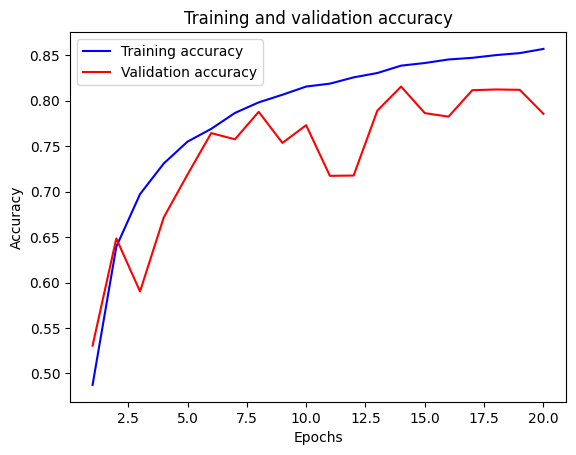

In [ ]:
import matplotlib.pyplot as plt

# Retrieve training and validation accuracies
train_acc = [0.4874, 0.6394, 0.6973, 0.7310, 0.7550, 0.7691, 0.7866, 0.7982, 0.8066, 0.8156, 0.8188, 0.8257, 0.8305, 0.8386, 0.8415, 0.8454, 0.8472,  0.8502, 0.8524, 0.8570]

val_acc = [0.5306, 0.6485, 0.5902, 0.6717, 0.7188, 0.7644, 0.7576, 0.7878, 0.7536, 0.7731, 0.7174, 0.7177, 0.7892, 0.8156, 0.7864, 0.7825, 0.8116, 0.8124, 0.8120, 0.7856]



# Plot training and validation accuracies
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model2 = model(input_shape)
model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


In [ ]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


# Fit the model on the batches generated by datagen.flow().
model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        )


# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Epoch 1/20


<ipython-input-10-898cdac8ad22>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


1563/1563 [==============================] - 67s 33ms/step - loss: 1.8475 - accuracy: 0.3780 - val_loss: 1.7610 - val_accuracy: 0.4155
Epoch 2/20
1563/1563 [==============================] - 51s 33ms/step - loss: 1.5742 - accuracy: 0.4823 - val_loss: 1.5229 - val_accuracy: 0.5027
Epoch 3/20
1563/1563 [==============================] - 50s 32ms/step - loss: 1.4513 - accuracy: 0.5300 - val_loss: 1.6667 - val_accuracy: 0.4643
Epoch 4/20
1563/1563 [==============================] - 50s 32ms/step - loss: 1.3553 - accuracy: 0.5708 - val_loss: 1.4536 - val_accuracy: 0.5326
Epoch 5/20
1563/1563 [==============================] - 50s 32ms/step - loss: 1.2750 - accuracy: 0.5989 - val_loss: 1.2358 - val_accuracy: 0.6087
Epoch 6/20
1563/1563 [==============================] - 49s 31ms/step - loss: 1.2105 - accuracy: 0.6204 - val_loss: 1.3633 - val_accuracy: 0.5863
Epoch 7/20
1563/1563 [==============================] - 50s 32ms/step - loss: 1.1590 - accuracy: 0.6409 - val_loss: 1.2024 - val_accura

In [ ]:
#trying different model with n = 4
#Resnet20 definition. Each block(identity/convolutional block) has 2 convolutional layer, each stack has 8 layers.
def model2(input_shape):
  #first convultional layer 3x3, filters = 16
  inputs = Input(shape = input_shape)
  x = resnet_layer(inputs=inputs,num_filters=16,conv_first=True)

  #first layer first stack
  y = resnet_layer(inputs=x,num_filters=16,strides=1)
  #conv,batch normalization,activation

  #second layer first stack
  y = resnet_layer(inputs=y,num_filters=16,strides=1,activation=None)
  #conv,batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #1st identity block over

  #third layer first stack
  y = resnet_layer(inputs=x,num_filters=16,strides=1)
  #conv, batch normalization, activation

  #fourth layer first stack
  y = resnet_layer(inputs=y,num_filters=16,strides=1,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #2nd identity block over

  #fifth layer first stack
  y = resnet_layer(inputs=x,num_filters=16,strides=1)
  #conv, batch normalization, activation

  #sixth layer first stack
  y = resnet_layer(inputs=y,num_filters=16,strides=1,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #3rd identity block over

  #seveth layer first stack
  y = resnet_layer(inputs=x,num_filters=16,strides=1)
  #conv, batch normalization, activation

  #eight layer first stack
  y = resnet_layer(inputs=y,num_filters=16,strides=1,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #4th identity block over

  #first layer second stack, num_filters =32 now
  y = resnet_layer(inputs=x,num_filters=32,strides=2)
  #conv, batch normalization, activation

  #second layer second stack
  y = resnet_layer(inputs=y,num_filters=32,activation=None)
  #conv, batch normalization

  x = resnet_layer(inputs=x,num_filters=32,kernel_size=1,strides=2,activation = None, batch_normalization=False)
  x = Add()([x,y])
  x = Activation('relu')(x)
  #convolutional block ends

  #third layer second stack
  y = resnet_layer(inputs=x,num_filters=32,strides=1)
  #conv, batch normalization, activation

  #fourth layer second stack
  y = resnet_layer(inputs=y,num_filters=32,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block

  #fifth layer second stack
  y = resnet_layer(inputs=x,num_filters=32,strides=1)
  #conv, batch normalization, activation

  #sixth layer second stack
  y = resnet_layer(inputs=y,num_filters=32,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block

  #seventh layer second stack
  y = resnet_layer(inputs=x,num_filters=32,strides=1)
  #conv, batch normalization, activation

  #eight layer second stack
  y = resnet_layer(inputs=y,num_filters=32,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block

  #first layer third stack, num_filters =64 now
  y = resnet_layer(inputs=x,num_filters=64,strides=2)
  #conv, batch normalization, activation

  #second layer third stack
  y = resnet_layer(inputs=y,num_filters=64,activation=None)
  #conv, batch normalization


  x = resnet_layer(inputs = x, num_filters=64, kernel_size=1,strides=2,activation=None,batch_normalization=False)
  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of convolutional block

  #third layer third stack
  y = resnet_layer(inputs=x,num_filters=64,strides=1)
  #conv, batch normalization, activation

  #fourth layer third stack
  y = resnet_layer(inputs=y,num_filters=64,activation=None)
  #conv, batch normalization

  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block

  #fifth layer third stack
  y = resnet_layer(inputs=x,num_filters=64,strides=1)
  # conv, batch normalization, activation

  #sixth layer third stack
  y = resnet_layer(inputs=y,num_filters=64,activation=None)
  #conv, batch normalization


  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block

  #seventh layer third stack
  y = resnet_layer(inputs=x,num_filters=64,strides=1)
  # conv, batch normalization, activation

  #eight layer third stack
  y = resnet_layer(inputs=y,num_filters=64,activation=None)
  #conv, batch normalization


  x = Add()([x,y])
  x = Activation('relu')(x)
  #end of identity block


  x = AveragePooling2D(pool_size=8)(x)
  y = Flatten()(x)
  outputs = Dense(10,activation = 'softmax', kernel_initializer='he_normal')(y)
  #outputs.shape

  model = Model(inputs=inputs,outputs=outputs)
  return model


In [ ]:
model2 = model2(input_shape)

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer= Adam(lr), metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 32, 32, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_19 (BatchN  (None, 32, 32, 16)  64          ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_19[0]

In [ ]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


# Fit the model on the batches generated by datagen.flow().
model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        )


# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/20


<ipython-input-14-898cdac8ad22>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


1563/1563 [==============================] - 52s 31ms/step - loss: 1.6830 - accuracy: 0.4613 - val_loss: 2.6751 - val_accuracy: 0.3607
Epoch 2/20
1563/1563 [==============================] - 46s 30ms/step - loss: 1.2824 - accuracy: 0.6119 - val_loss: 1.5794 - val_accuracy: 0.5544
Epoch 3/20
1563/1563 [==============================] - 51s 33ms/step - loss: 1.0872 - accuracy: 0.6858 - val_loss: 1.2071 - val_accuracy: 0.6490
Epoch 4/20
1563/1563 [==============================] - 50s 32ms/step - loss: 0.9813 - accuracy: 0.7246 - val_loss: 1.0155 - val_accuracy: 0.7238
Epoch 5/20
1563/1563 [==============================] - 48s 30ms/step - loss: 0.9080 - accuracy: 0.7535 - val_loss: 0.9487 - val_accuracy: 0.7463
Epoch 6/20
1563/1563 [==============================] - 49s 31ms/step - loss: 0.8557 - accuracy: 0.7714 - val_loss: 1.2036 - val_accuracy: 0.6866
Epoch 7/20
1563/1563 [==============================] - 48s 30ms/step - loss: 0.8149 - accuracy: 0.7881 - val_loss: 0.9241 - val_accura

In [ ]:
model2.save("resnet_n_4.h5")


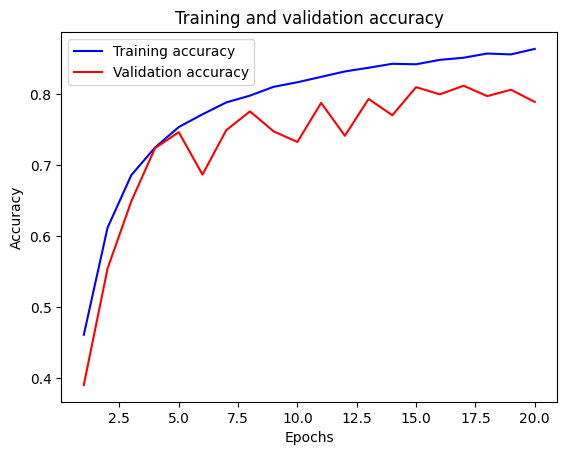

In [ ]:
import matplotlib.pyplot as plt

# Retrieve training and validation accuracies
train_acc = [0.4613, 0.6119, 0.6858, 0.7246, 0.7535, 0.7714, 0.7881, 0.7977, 0.8101, 0.8165, 0.8241, 0.8317, 0.8369, 0.8425, 0.8418, 0.8480, 0.8510, 0.8569, 0.8557, 0.8634]

val_acc = [0.3907, 0.5544, 0.6490, 0.7238, 0.7463, 0.6866, 0.7490, 0.7755, 0.7474, 0.7325, 0.7875, 0.7412, 0.7930, 0.7701, 0.8096, 0.7995, 0.8116, 0.7970, 0.8060, 0.7888]



# Plot training and validation accuracies
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()